In [1]:
# Libraries we need to use
import numpy as np
import cv2
import dlib
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from ipywidgets import FileUpload
from IPython.display import display, clear_output
import io


In [2]:
# Initialize the detector and predictor 
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [3]:
# Analyze color 
def analyze_color(region):
    if region.size == 0 or region.reshape((-1, 3)).shape[0] < 2:
        return (0, 0, 0)
    pixels = region.reshape((-1, 3))
    pixels = np.float32(pixels)
    k = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    _, counts = np.unique(labels, return_counts=True)
    dominant_color = centers[np.argmax(counts)]
    return tuple(int(c) for c in dominant_color)

In [4]:
# Determine face shape 
def determine_face_shape(landmarks, image):
    jaw_width = landmarks.part(16).x - landmarks.part(0).x
    face_height = landmarks.part(8).y - landmarks.part(19).y
    ratio = jaw_width / float(face_height)
    if ratio <= 0.8:
        return "Oval"
    elif 0.8 < ratio <= 1:
        return "Round"
    else:
        return "Square"
     

In [5]:
# Color name to BGR mapping
color_name_to_bgr = {
    'gray': (128, 128, 128),
    'black': (0, 0, 0),
    'blue': (255, 0, 0),
    'pink': (180, 105, 255),
    'grayblack': (64, 64, 64),
}


In [6]:
# Color distance calculation
def color_distance(color1, color2):
    return np.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(color1, color2)))


In [7]:

# Find nearest color name
def find_nearest_color_name(detected_color, color_map):
    nearest_color_name = min(color_map.keys(), key=lambda name: color_distance(detected_color, color_map[name]))
    return nearest_color_name

In [8]:
# Mock image data for the images we will generate
image_data = [
    ('pants', 'smart', 'gray', 'pull&bear', None, 'Photos_DB/pull&bear_pants_smart_gray.jpeg'),
    ('pants', 'smart', 'grayblack', 'pull&bear', None, 'Photos_DB/pull&bear_pants_smart_grayblack.jpeg'),
    ('pants', 'stripped', 'blue', 'pull&bear', None, 'Photos_DB/pull&bear_pants_stripped_blue.jpeg'),
    ('skirt', 'midi', 'black', 'pull&bear', None, 'Photos_DB/pull&bear_skirt_midi_black.jpeg'),
    ('hoodie', 'winter', 'pink', 'zara', None, 'Photos_DB/zara_hoodie_winter_pink.jpeg'),
    ('shirt', 'hippie', 'gray', 'zara', None, 'Photos_DB/zara_shirt_hippie_gray.jpeg'),
    ('shirt', 'tshirt', 'black', 'zara', None, 'Photos_DB/zara_shirt_tshirt_black.jpeg'),
    ('skirt', 'jean', 'blue', 'zara', None, 'Photos_DB/zara_skirt_jean_blue.jpeg'),
    ('turtleneck', 'name', 'pink', 'zara', None, 'Photos_DB/zara_turtleneck_name_pink.jpeg')
]

In [9]:
# Fetch clothes function
def fetch_clothes(face_shape, eye_color, hair_color, skin_color):
    hair_color_name = find_nearest_color_name(hair_color, color_name_to_bgr)
    eye_color_name = find_nearest_color_name(eye_color, color_name_to_bgr)
    filtered_data = [item for item in image_data if eye_color_name in item[2] or hair_color_name in item[2]]
    return filtered_data

In [10]:
# Display reccomandations
def display_recommendations_in_notebook(recommendations):
    columns = ['Category', 'Style', 'Color', 'Brand', 'Attribute', 'ImagePath']
    df = pd.DataFrame(recommendations, columns=columns)
    df['Image'] = [f'<img src="{path}" width="100" height="100">' for path in df['ImagePath']]
    display(HTML(df.to_html(escape=False, index=False)))

In [11]:
# Detect features and display recommendations
def detect_features_and_recommend(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image at {image_path}")
        return

    # Display the input image
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        print("No faces detected.")
        return

    for face in faces:
        landmarks = predictor(gray, face)
        left_eye_region = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
        (x, y, w, h) = cv2.boundingRect(cv2.convexHull(left_eye_region))
        left_eye = image[y:y+h, x:x+w]
        left_eye_color = analyze_color(left_eye)
        
        forehead_region = image[landmarks.part(24).y:landmarks.part(19).y, landmarks.part(18).x:landmarks.part(25).x]
        hair_color = analyze_color(forehead_region)
        
        skin_region = image[landmarks.part(29).y:landmarks.part(30).y, landmarks.part(39).x:landmarks.part(42).x]
        skin_color = analyze_color(skin_region)
        
        face_shape = determine_face_shape(landmarks, image)
        print(f"Detected Left Eye Color (BGR): {left_eye_color}")
        print(f"Detected Hair Color (BGR): {hair_color}")
        print(f"Detected Skin Color (BGR): {skin_color}")
        print(f"Detected Face Shape: {face_shape}")
        
        recommendations = fetch_clothes(face_shape, left_eye_color, hair_color, skin_color)

        # Limit to 2 recommendations per person-> many reccomandations the first ti
        display_recommendations_in_notebook(recommendations[:2])


Enter the path to your image: woman.jpg


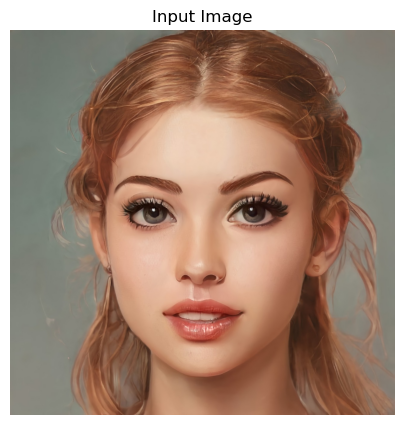

Detected Left Eye Color (BGR): (35, 42, 63)
Detected Hair Color (BGR): (160, 185, 223)
Detected Skin Color (BGR): (118, 153, 211)
Detected Face Shape: Square


Category,Style,Color,Brand,Attribute,ImagePath,Image
pants,smart,grayblack,pull&bear,None,Photos_DB/pull&bear_pants_smart_grayblack.jpeg,
hoodie,winter,pink,zara,None,Photos_DB/zara_hoodie_winter_pink.jpeg,


In [12]:
def main():
    # Prompt the user for an image 
    image_path = input("Enter the path to your image: ")
    detect_features_and_recommend(image_path)

if __name__ == "__main__":
    main()